In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)

plt.rcParams["figure.dpi"] = 140

# Data: (Params, Tokens, Compute PF-days, Final Loss)
data = [
    (100e6,  10e9,   0.1, 2.50),
    (300e6,  30e9,   0.5, 2.10),
    (1e9,    100e9,  2.0, 1.75),
    (3e9,    300e9, 10.0, 1.50),
]
df = pd.DataFrame(data, columns=["N_params", "D_tokens", "C_pf_days", "loss"])
df


,N_params,D_tokens,C_pf_days,loss
0,1.000000e+08,1.000000e+10,0.1,2.50
1,3.000000e+08,3.000000e+10,0.5,2.10
2,1.000000e+09,1.000000e+11,2.0,1.75
3,3.000000e+09,3.000000e+11,10.0,1.50


In [18]:
def scaling_law(X, L_inf, k, a, b):
    N, D = X
    return L_inf + k * (N**(-a)) * (D**(-b))

N = df["N_params"].values
D = df["D_tokens"].values
L = df["loss"].values

p0 = [1.2, 50.0, 0.08, 0.08]
bounds = ([0.0, 0.0, 0.0, 0.0], [10.0, 1e6, 2.0, 2.0])

popt, pcov = curve_fit(scaling_law, (N, D), L, p0=p0, bounds=bounds, maxfev=200000)
L_inf, k, a, b = popt

df["loss_fit"] = scaling_law((N, D), *popt)

print("Fitted scaling law:")
print(f"  L(N,D) = L_inf + k*N^(-a)*D^(-b)")
print(f"  L_inf = {L_inf:.4f}, k = {k:.4f}, a = {a:.4f}, b = {b:.4f}")
df


Fitted scaling law:
  L(N,D) = L_inf + k*N^(-a)*D^(-b)
  L_inf = 0.4927, k = 152.9337, a = 0.0735, b = 0.1294


,N_params,D_tokens,C_pf_days,loss,loss_fit
0,1.000000e+08,1.000000e+10,0.1,2.50,2.500257
1,3.000000e+08,3.000000e+10,0.5,2.10,2.099152
2,1.000000e+09,1.000000e+11,2.0,1.75,1.750999
3,3.000000e+09,3.000000e+11,10.0,1.50,1.499592


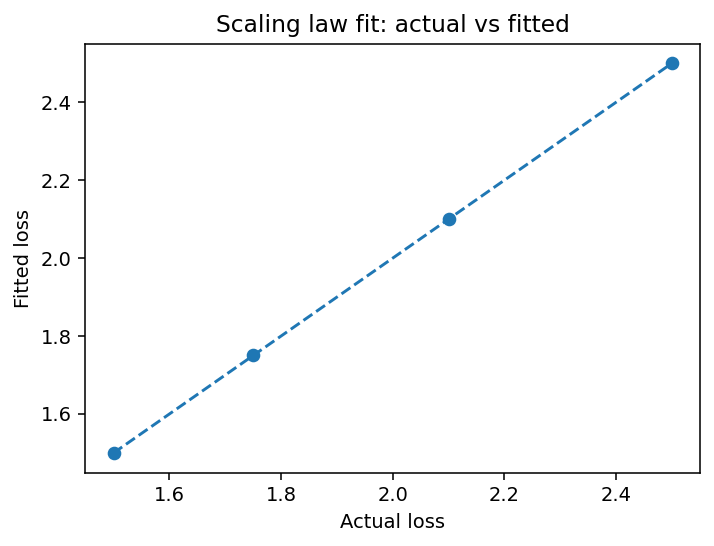

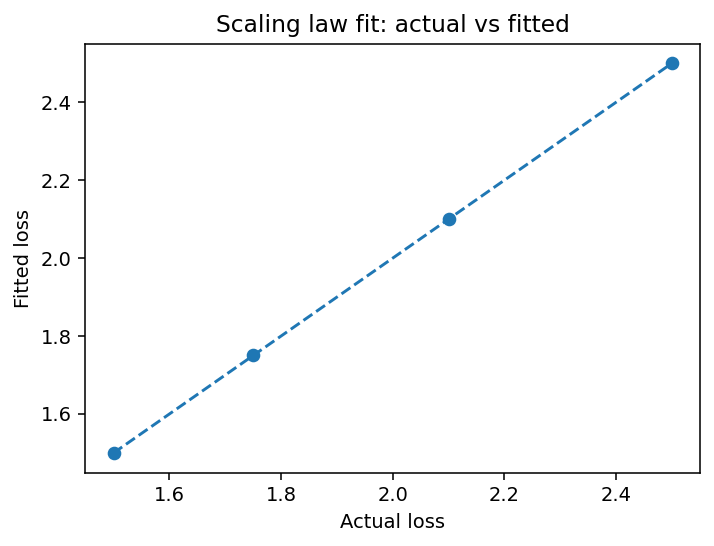

In [19]:
plt.figure(figsize=(5.2,4))
plt.scatter(df["loss"], df["loss_fit"])
lo, hi = min(df["loss"].min(), df["loss_fit"].min()), max(df["loss"].max(), df["loss_fit"].max())
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlabel("Actual loss")
plt.ylabel("Fitted loss")
plt.title("Scaling law fit: actual vs fitted")
plt.tight_layout()
plt.show()
plt.figure(figsize=(5.2,4))
plt.scatter(df["loss"], df["loss_fit"])
lo, hi = min(df["loss"].min(), df["loss_fit"].min()), max(df["loss"].max(), df["loss_fit"].max())
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlabel("Actual loss")
plt.ylabel("Fitted loss")
plt.title("Scaling law fit: actual vs fitted")
plt.tight_layout()
plt.show()


In [20]:
N_q = 10e9
D_q = 1e12
pred_loss = scaling_law((np.array([N_q]), np.array([D_q])), *popt)[0]
print(f"Predicted loss for 10B params, 1T tokens: {pred_loss:.4f}")


Predicted loss for 10B params, 1T tokens: 1.2814


In [21]:
budget = 20.0

# Assumption: compute scales ~ N*D (common transformer training scaling).
# We estimate proportionality constant c from provided runs: C ≈ c*(N*D)
ND = df["N_params"].values * df["D_tokens"].values
C = df["C_pf_days"].values
c = np.sum(C * ND) / np.sum(ND * ND)

ND_budget = budget / c
print(f"Compute model: C ≈ c*N*D with c = {c:.3e}")
print(f"Budget constraint: N*D <= {ND_budget:.3e}")

# Grid search
N_grid = np.logspace(8, np.log10(3e10), 160)
Dmax_global = ND_budget / N_grid.min()
D_grid = np.logspace(10, np.log10(Dmax_global), 200)


best = None
for Ng in N_grid:
    Dmax = ND_budget / Ng
    feasible = D_grid[D_grid <= Dmax]
    if feasible.size == 0:
        continue
    losses = scaling_law((np.full_like(feasible, Ng), feasible), *popt)
    j = np.argmin(losses)
    Dg = feasible[j]
    Lg = float(losses[j])
    Cg = c * Ng * Dg
    if best is None or Lg < best["loss"]:
        best = {"N": Ng, "D": Dg, "loss": Lg, "C": Cg}

best


Compute model: C ≈ c*N*D with c = 1.122e-20
Budget constraint: N*D <= 1.782e+21


{'N': np.float64(100000000.0),
 'D': np.float64(17818960085174.797),
 'loss': 1.2548583977742507,
 'C': np.float64(19.999999999999993)}

Recommended allocation under 20 PF-days (min predicted loss):
  Model size N ≈ 100.00M params
  Dataset size D ≈ 17.82T tokens
  Expected loss ≈ 1.2549
  Compute used ≈ 20.00 PF-days


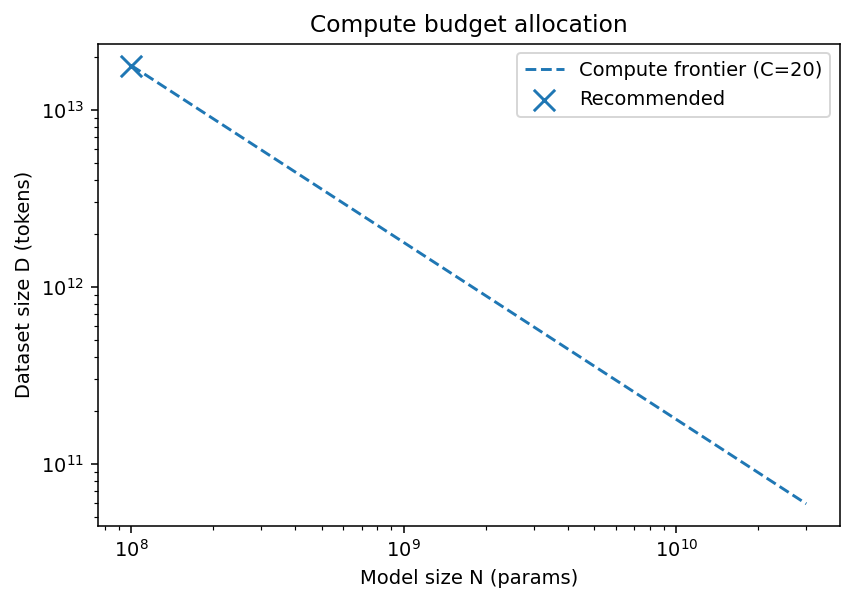

In [22]:
def pretty(x):
    if x >= 1e12: return f"{x/1e12:.2f}T"
    if x >= 1e9:  return f"{x/1e9:.2f}B"
    if x >= 1e6:  return f"{x/1e6:.2f}M"
    return str(x)

print("Recommended allocation under 20 PF-days (min predicted loss):")
print(f"  Model size N ≈ {pretty(best['N'])} params")
print(f"  Dataset size D ≈ {pretty(best['D'])} tokens")
print(f"  Expected loss ≈ {best['loss']:.4f}")
print(f"  Compute used ≈ {best['C']:.2f} PF-days")

# Plot compute frontier N*D = constant
front_N = np.logspace(8, np.log10(3e10), 200)
front_D = ND_budget / front_N

plt.figure(figsize=(6.2,4.4))
plt.plot(front_N, front_D, linestyle="--", label="Compute frontier (C=20)")
plt.scatter([best["N"]], [best["D"]], marker="x", s=120, label="Recommended")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Model size N (params)")
plt.ylabel("Dataset size D (tokens)")
plt.title("Compute budget allocation")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
writeup = f"""
Methodology (brief)

1) Scaling law fit
   I modeled final loss as:
   L(N, D) = L_inf + k * N^(-a) * D^(-b),
   and fit (L_inf, k, a, b) to the provided runs via non-linear least squares.

2) Prediction
   Using the fitted law, I predicted the loss for N=10B parameters and D=1T tokens.

3) Compute-budget optimization (20 PF-days)
   To allocate compute across model size and dataset size, I used the common approximation that
   training compute scales proportionally to N * D (parameters × tokens).
   I estimated the proportionality constant from the provided compute numbers and then searched
   over feasible (N, D) pairs under the constraint C <= 20 PF-days, selecting the pair with
   the lowest predicted loss.

Key results
- Fitted exponents: a={a:.4f}, b={b:.4f} (interpret with caution due to only 4 points)
- Predicted loss at (10B, 1T): {pred_loss:.4f}
- Recommended allocation under 20 PF-days:
  N≈{best['N']/1e9:.2f}B params, D≈{best['D']/1e12:.2f}T tokens (uses {best['C']:.2f} PF-days)

Assumptions & limitations
- Only 4 datapoints → parameter estimates are unstable; results are best viewed as approximate.
- Extrapolation beyond observed scale (up to 3B/300B) adds uncertainty.
- Compute ~ N*D is a simplification; real systems include overheads and efficiency differences.
- Tokens are assumed equal-quality; data mixture/quality effects are ignored.
"""
print(writeup)



Methodology (brief)

1) Scaling law fit
   I modeled final loss as:
   L(N, D) = L_inf + k * N^(-a) * D^(-b),
   and fit (L_inf, k, a, b) to the provided runs via non-linear least squares.

2) Prediction
   Using the fitted law, I predicted the loss for N=10B parameters and D=1T tokens.

3) Compute-budget optimization (20 PF-days)
   To allocate compute across model size and dataset size, I used the common approximation that
   training compute scales proportionally to N * D (parameters × tokens).
   I estimated the proportionality constant from the provided compute numbers and then searched
   over feasible (N, D) pairs under the constraint C <= 20 PF-days, selecting the pair with
   the lowest predicted loss.

Key results
- Fitted exponents: a=0.0735, b=0.1294 (interpret with caution due to only 4 points)
- Predicted loss at (10B, 1T): 1.2814
- Recommended allocation under 20 PF-days:
  N≈0.10B params, D≈17.82T tokens (uses 20.00 PF-days)

Assumptions & limitations
- Only 4 datapoin